# Análisis de Uso de Servicios de Telefonía Virtual para CallMeMaybe
# Telecomunicaciones

Presentación: https://docs.google.com/presentation/d/1Z-0Fh8oqQsWDSBRtsLVymQsG8m-YCE9a_bm-aoRGjNY/edit?usp=sharing

## Introducción 

Con el fin de mejorar la eficiencia operativa y ofrecer un mejor servicio a sus clientes, CallMeMaybe ha comenzado a implementar una serie de herramientas y funcionalidades avanzadas. La compañía se dedica a proporcionar servicios de telefonía virtual a organizaciones que requieren una gestión eficaz de llamadas, ya sean entrantes o salientes. Además, la red de CallMeMaybe permite que los operadores se comuniquen entre sí mediante llamadas internas. En este contexto, se están utilizando datasets detallados para analizar el uso del servicio, lo que facilita la identificación de patrones y permite mejorar el monitoreo del desempeño de los operadores, contribuyendo a una mayor optimización del servicio.







## Objetivo

**Identificar operadores ineficaces** 

**Los opersdores del call center estan haciendo bien su trabajo**

## Exploración de datos 

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt
from plotly import graph_objects as go
import seaborn as sns 
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
from scipy import stats as st
import pandas as pd
import numpy as np

In [2]:
telecom_df = pd.read_csv('/datasets/telecom_dataset_us.csv')

In [3]:
telecom_df

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
...,...,...,...,...,...,...,...,...,...
53897,168606,2019-11-10 00:00:00+03:00,out,True,957922.0,True,1,0,38
53898,168606,2019-11-11 00:00:00+03:00,out,True,957922.0,False,2,479,501
53899,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190
53900,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190


In [4]:
telecom_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


Es necesario cambiar el formato de las columnas, como en el caso de fecha. 

In [5]:
telecom_df['date'] = pd.to_datetime(telecom_df['date'])

Tenemos un formato de datetime64[ns, pytz.FixedOffset(180)] lo que significa un desplazamiento de +3 horas con respecto al Tiempo Universal Coordinado (UTC), o UTC+3.

especificare el formato que necesito con la función .dt.strftime('%Y-%m-%d') y posteriormente volvere a usar la función to_datetime para transformar el formato .

In [6]:
telecom_df['date'] =  telecom_df['date'].dt.strftime('%Y-%m-%d')

In [7]:
telecom_df['user_id'] = telecom_df['user_id'].astype(str)

In [8]:
telecom_df.head() 

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
1,166377,2019-08-05,out,True,880022.0,True,3,0,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18
4,166377,2019-08-05,out,False,880022.0,True,3,0,25


In [9]:
telecom_df['date'] = pd.to_datetime(telecom_df['date'])

In [10]:
telecom_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              53902 non-null  object        
 1   date                 53902 non-null  datetime64[ns]
 2   direction            53902 non-null  object        
 3   internal             53785 non-null  object        
 4   operator_id          45730 non-null  float64       
 5   is_missed_call       53902 non-null  bool          
 6   calls_count          53902 non-null  int64         
 7   call_duration        53902 non-null  int64         
 8   total_call_duration  53902 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 3.3+ MB


Parece que tenemos dos columnas que les falta información ... veamos que pasa 

In [11]:
telecom_df['operator_id'].isna().sum() 

8172

In [12]:
telecom_df[telecom_df['operator_id'].isna()]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
7,166377,2019-08-05,in,False,NaN,True,6,0,35
9,166377,2019-08-06,in,False,NaN,True,4,0,62
17,166377,2019-08-07,in,False,NaN,True,2,0,24
27,166377,2019-08-12,in,False,NaN,True,2,0,34
...,...,...,...,...,...,...,...,...,...
53876,168601,2019-11-27,in,False,NaN,True,2,0,39
53880,168601,2019-11-28,in,False,NaN,True,1,0,19
53889,168603,2019-11-28,in,False,NaN,True,1,0,30
53893,168606,2019-11-08,in,False,NaN,True,6,0,121


Son demasiados operadores que no estan... 
Como no sabemos de quienes son y son nuestros objetivos a eveluar se decidio eliminar esto datos para evitar que falle nuestro analisis 

In [13]:
telecom_df['internal'].isna().sum()

117

Nuevamente otra columna al que le faltan datos ... aunque puede que esto no afecte a todo nuestro análisis. 
Aunque no se borre remplazaremos los datos.

In [14]:
telecom_df['internal'].fillna('Otro', inplace=True)
telecom_df['operator_id'].fillna('-', inplace=True)

In [15]:
telecom_df.duplicated().sum()

4900

Hay 4900 duplicados, los borraremos para evitar algun sesgo en los resultados

In [16]:
telecom_df.drop_duplicates(inplace = True)


(telecom_df.duplicated().sum())

0

In [17]:
clients_df =pd.read_csv('/datasets/telecom_clients_us.csv')

In [18]:
clients_df

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16
...,...,...,...
727,166554,B,2019-08-08
728,166911,B,2019-08-23
729,167012,B,2019-08-28
730,166867,B,2019-08-22


In [19]:
clients_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [20]:
clients_df['date_start'] = pd.to_datetime(clients_df['date_start'])

## Identificar operadores ineficaces

Para identificar a los operadores menos eficaces, según los criterios dados se tomaran en cuenta los siguientes puntos: 

Un gran número de llamadas perdidas (tanto internas como externas).

Un tiempo de espera largo (lo cual se refleja en la diferencia entre total_call_duration y call_duration).

Un bajo número de llamadas salientes (solo si se espera que realice llamadas salientes).

Una comparación entre los operadores más eficaces y los menos eficientes 




Podemos identificar a los operadores ineficaces usando un umbral que represente un "alto" número de llamadas perdidas, un "alto" tiempo de espera, y un "bajo" número de llamadas salientes.

### Número de llamadas perdidas 

In [21]:
missed_calls = telecom_df.groupby(
    ['operator_id', 'is_missed_call']).agg(calls_count=('calls_count', 'count')).unstack(fill_value=0)


missed_calls.columns = ['False', 'True']


missed_calls['Total'] = missed_calls['False'] + missed_calls['True']


missed_calls = missed_calls.reset_index()


print(missed_calls)

     operator_id  False  True  Total
0       879896.0     70    47    117
1       879898.0    138    89    227
2       880020.0     14     6     20
3       880022.0     41    29     70
4       880026.0     95    87    182
...          ...    ...   ...    ...
1088    972412.0      3     2      5
1089    972460.0      4     3      7
1090    973120.0      1     1      2
1091    973286.0      1     0      1
1092           -    113  7343   7456

[1093 rows x 4 columns]


In [22]:
missed_calls.columns = ['operator_id','answer', 'missed', 'total']

In [23]:
missed_calls

,operator_id,answer,missed,total
0,879896.0,70,47,117
1,879898.0,138,89,227
2,880020.0,14,6,20
3,880022.0,41,29,70
4,880026.0,95,87,182
...,...,...,...,...
1088,972412.0,3,2,5
1089,972460.0,4,3,7
1090,973120.0,1,1,2
1091,973286.0,1,0,1


Vamos a representaar mejor esta tabla...y también modificaremos sus nombres

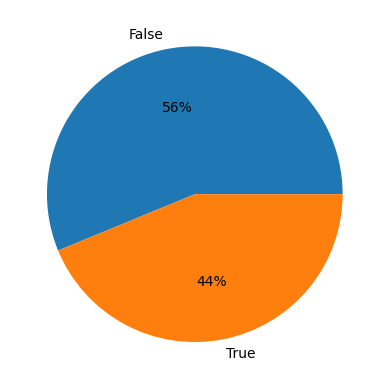

In [24]:
pie_df = telecom_df.groupby('is_missed_call')['calls_count'].count().reset_index()

plt.pie(pie_df['calls_count'], labels=pie_df['is_missed_call'],autopct='%.0f%%')
plt.show()

Parece que el 44% de las llamadas son perdidas...

In [25]:
missed_calls['missed%'] = missed_calls['missed']/missed_calls['total']*100 

In [26]:
missed_calls.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   operator_id  1093 non-null   object 
 1   answer       1093 non-null   int64  
 2   missed       1093 non-null   int64  
 3   total        1093 non-null   int64  
 4   missed%      1093 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 42.8+ KB


In [27]:
porcent_missed = missed_calls[missed_calls['missed%']>=80]
porcent_missed.reset_index()

,index,operator_id,answer,missed,total,missed%
0,7,881278.0,1,7,8,87.500000
1,15,883018.0,0,1,1,100.000000
2,27,885682.0,0,3,3,100.000000
3,92,891976.0,0,1,1,100.000000
4,152,898434.0,1,5,6,83.333333
5,160,899076.0,0,2,2,100.000000
6,247,905308.0,0,1,1,100.000000
7,253,905480.0,0,1,1,100.000000
8,324,909308.0,0,3,3,100.000000
9,381,914272.0,0,1,1,100.000000


In [28]:
porcent_missed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 7 to 1092
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   operator_id  39 non-null     object 
 1   answer       39 non-null     int64  
 2   missed       39 non-null     int64  
 3   total        39 non-null     int64  
 4   missed%      39 non-null     float64
dtypes: float64(1), int64(3), object(1)
memory usage: 1.8+ KB


Son 38 operadores con más del 80% de las llamadas perdidas ... aunque la mayoria no se saben cuantas llamadas contestadas tienen 

### tiempo de espera

In [29]:
telecom_df['wait_time'] = telecom_df['total_call_duration'] - telecom_df['call_duration']

# Agrupar por operador y calcular el tiempo de espera promedio
wait_time_per_operator = telecom_df.groupby('operator_id').agg(
    avg_wait_time=('wait_time', 'mean')
).reset_index()

In [30]:
wait_time_per_operator

,operator_id,avg_wait_time
0,879896.0,104.914530
1,879898.0,457.696035
2,880020.0,14.000000
3,880022.0,53.971429
4,880026.0,121.978022
...,...,...
1088,972412.0,210.000000
1089,972460.0,88.571429
1090,973120.0,10.000000
1091,973286.0,88.000000


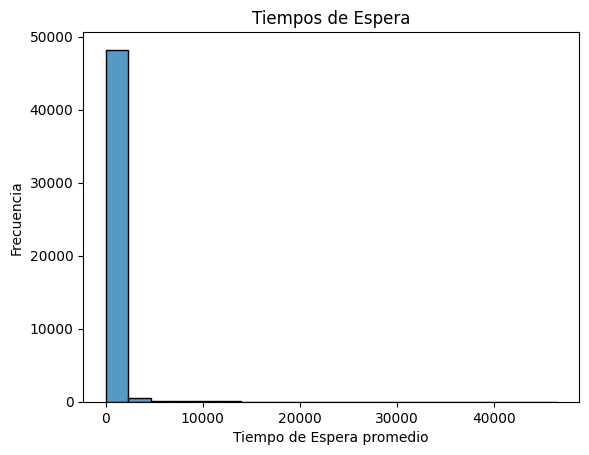

In [31]:
sns.histplot(telecom_df['wait_time'], bins= 20)
plt.title('Tiempos de Espera')
plt.xlabel('Tiempo de Espera promedio')
plt.ylabel('Frecuencia')
plt.show()

In [32]:
telecom_df['wait_time'].median() 

55.0

Usamos la media de los datos para conocer el valor representativo, siendo 55 segundos...
El promedio de estos valores es de : 

In [33]:
telecom_df['wait_time'].mean() 

290.27611117913557

utilizaremos este número para identificar a los operadores que tengan un alto tiempo de espera

In [34]:
waiting_time_df = telecom_df.groupby('operator_id')['wait_time'].median().sort_values( ascending = False).reset_index()

In [35]:
waiting_time_df

,operator_id,wait_time
0,885890.0,4525.0
1,929428.0,3030.0
2,925922.0,3007.0
3,908640.0,2885.0
4,919364.0,2784.0
...,...,...
1088,955068.0,0.0
1089,958458.0,0.0
1090,922486.0,0.0
1091,953460.0,0.0


In [36]:
waiting_time_operator = waiting_time_df[waiting_time_df['wait_time']> 290].sort_values(by = 'wait_time', ascending = False).reset_index()

waiting_time_operator


,index,operator_id,wait_time
0,0,885890.0,4525.0
1,1,929428.0,3030.0
2,2,925922.0,3007.0
3,3,908640.0,2885.0
4,4,919364.0,2784.0
...,...,...,...
145,145,883940.0,309.0
146,146,939762.0,305.0
147,147,947652.0,304.5
148,148,947604.0,303.0


### Número de llamadas salientes

In [37]:

outgoing_calls = telecom_df[telecom_df['direction'] == 'out']

incoming_calls = telecom_df[telecom_df['direction'] == 'in']


outgoing_calls_count = outgoing_calls.groupby('operator_id')['calls_count'].sum().reset_index()
outgoing_calls_count = outgoing_calls_count.rename(columns={'calls_count': 'outgoing_calls'})


incoming_calls_count = incoming_calls.groupby('operator_id')['calls_count'].sum().reset_index()
incoming_calls_count = incoming_calls_count.rename(columns={'calls_count': 'incoming_calls'})


total_calls_count = telecom_df.groupby('operator_id')['calls_count'].sum().reset_index()
total_calls_count = total_calls_count.rename(columns={'calls_count': 'total_calls'})


number_calls = pd.merge(outgoing_calls_count, incoming_calls_count, on='operator_id', how='outer')
number_calls = pd.merge(number_calls, total_calls_count, on='operator_id', how='outer')




In [38]:
number_calls.dropna(inplace=True)

In [39]:
number_calls['out_calls%'] = number_calls['outgoing_calls'] / number_calls['total_calls']*100

In [40]:
number_calls

,operator_id,outgoing_calls,incoming_calls,total_calls,out_calls%
0,879896.0,872.0,58.0,930,93.763441
1,879898.0,7209.0,104.0,7313,98.577875
2,880020.0,38.0,7.0,45,84.444444
3,880022.0,189.0,8.0,197,95.939086
4,880026.0,2208.0,24.0,2232,98.924731
...,...,...,...,...,...
872,970252.0,5.0,1.0,6,83.333333
873,970254.0,9.0,3.0,12,75.000000
879,972412.0,60.0,1.0,61,98.360656
880,972460.0,50.0,1.0,51,98.039216


In [41]:
out_calls_operator = number_calls[number_calls['out_calls%']<=20].sort_values(by= 'out_calls%', ascending = False).reset_index()
out_calls_operator

,index,operator_id,outgoing_calls,incoming_calls,total_calls,out_calls%
0,486,930816.0,1.0,4.0,5,20.000000
1,514,934000.0,2.0,8.0,10,20.000000
2,325,917876.0,2.0,8.0,10,20.000000
3,680,945058.0,1.0,4.0,5,20.000000
4,274,911310.0,95.0,401.0,496,19.153226
5,73,891908.0,9.0,39.0,48,18.750000
6,215,906070.0,71.0,324.0,395,17.974684
7,189,904044.0,23.0,108.0,131,17.557252
8,672,944560.0,1.0,5.0,6,16.666667
9,747,949420.0,1.0,5.0,6,16.666667


Estos 56 operadores son los que tienen menos del 20% de sus llamadas como salientes...

### Identificar operadores ineficaces 

Ahora que hemos realizado las pruebas y determinado los operadores con numeros altos en tiempo de espera, porcentajes bajos en llamadas salientes y porcentajes altos en llamadas perdidas, Un operador se considerará ineficaz si aparece en al menos dos de las tres tablas.

In [42]:

inefficient_operators = out_calls_operator[out_calls_operator['operator_id'].isin(waiting_time_operator['operator_id']) | 
                                           out_calls_operator['operator_id'].isin(porcent_missed['operator_id'])]

In [43]:
efficient_operators = out_calls_operator[~out_calls_operator['operator_id'].isin(inefficient_operators['operator_id'])]

In [44]:
inefficient_operators

,index,operator_id,outgoing_calls,incoming_calls,total_calls,out_calls%
48,379,919794.0,21.0,1136.0,1157,1.815039
50,377,919790.0,23.0,1578.0,1601,1.436602
52,376,919554.0,11.0,1182.0,1193,0.922045
54,882,-,521.0,104043.0,104564,0.498259
56,350,919206.0,1.0,926.0,927,0.107875


Esots 5 operadores se identifican como ineficaces, ya que aparecen en más de una tabla..

## Prueba de hipotesis 

### un operador ineficaz tiene gran cantidad de llamadas entrantes perdidas (internas y externas)

Hipótesis nula: No hay una relación significativa entre la ineficacia del operador y la cantidad de llamadas entrantes perdidas.

In [45]:
inefficient_missed_calls = porcent_missed[porcent_missed['operator_id'].isin(inefficient_operators['operator_id'])]['missed']
effecient_missed_calls = porcent_missed[porcent_missed['operator_id'].isin(efficient_operators['operator_id'])]['missed']

In [46]:
missed_calls

,operator_id,answer,missed,total,missed%
0,879896.0,70,47,117,40.170940
1,879898.0,138,89,227,39.207048
2,880020.0,14,6,20,30.000000
3,880022.0,41,29,70,41.428571
4,880026.0,95,87,182,47.802198
...,...,...,...,...,...
1088,972412.0,3,2,5,40.000000
1089,972460.0,4,3,7,42.857143
1090,973120.0,1,1,2,50.000000
1091,973286.0,1,0,1,0.000000


In [47]:
# umbral en 80%
umbral = missed_calls['missed%'].quantile(0.80)
inefficent_calls_h = missed_calls[missed_calls['missed%'] >= umbral]
efficent_calls_h = missed_calls[missed_calls['missed%'] < umbral]

alpha = 0.05

count = [len(inefficent_calls_h), len(efficent_calls_h)]
nobs = [len(missed_calls), len(missed_calls)]
stat, p_value = proportions_ztest(count, nobs)

print(f'Z-statistic: {stat}, P-value: {p_value}')

Z-statistic: -26.22197453977994, P-value: 1.4926251632496143e-151



debido a que el valor p es de 1.492 y esmayor que 0.05, podemos rechazar la hipótesis nula y concluimos que no hay diferencia significativa entre la cantidad de llamadas entrantes perdidas entre los operadores ineficaces y eficaces.


###  Un operador ineficaz, tiene un tiempo de espera prolongado para las llamadas entrantes.

Hipotesis nula: Hay una diferencia significativa en el tiempo de espera de las llamadas entrantes entre los operadores ineficaces y los operadores eficaces.

In [48]:
waiting_time_df


,operator_id,wait_time
0,885890.0,4525.0
1,929428.0,3030.0
2,925922.0,3007.0
3,908640.0,2885.0
4,919364.0,2784.0
...,...,...
1088,955068.0,0.0
1089,958458.0,0.0
1090,922486.0,0.0
1091,953460.0,0.0


In [49]:
inefficient_wait_time = waiting_time_df[waiting_time_df['operator_id'].isin(inefficient_operators['operator_id'])]['wait_time']
effecient_wait_time = waiting_time_df[waiting_time_df['operator_id'].isin(efficient_operators['operator_id'])]['wait_time']


In [50]:
t_statistic, p_value = st.ttest_ind(inefficient_wait_time, effecient_wait_time )

print(f'T-statistic: {t_statistic}, P-value: {p_value}')

T-statistic: 9.617273285782492, P-value: 2.2158487073040012e-13


Debido que  el valor p es de 2.2158, mayor que 0.05, No podemos rechazar la hipotesis nula

### El número de llamadas salientes de los operadores ineficaces.

Hipotesis nula: El número de llamadas salientes de los operadores ineficaces es diferente al de los operadores eficaces

In [51]:
# Obtener el número de llamadas salientes para los operadores ineficaces y eficaces
inefficient_out_calls = number_calls[number_calls['operator_id'].isin(inefficient_operators['operator_id'])]['outgoing_calls']
efficient_out_calls = number_calls[number_calls['operator_id'].isin(efficient_operators['operator_id'])]['outgoing_calls']


In [52]:
t_statistic, p_value = st.ttest_ind(inefficient_out_calls, efficient_out_calls)

print(f'T-statistic: {t_statistic}, P-value: {p_value}')

T-statistic: 1.6627999573668488, P-value: 0.10204168928273155


Dado que el p-value (0.102) es mayor que 0.05, no podemos rechazar la hipótesis nula (H₀). 

Hola revisor, disculpe que he mandado esto sin terminar, me estanque un poco ya que a la hora de querer filtrar mis resultados de operadores ineficientes me sale que no hay ninguno, lo intente hacer de dos formas pero ambas me salieron sin resultados, no sé que esta mal o si le estoy dando un mal angulo a esto, podría ayudartme con eso? 

## Conclusiones

A lo largo de las pruebas estadísticas realizadas, todas las hipótesis nulas no fueron rechazadas, lo que indica que existen diferencias significativas entre los operadores ineficaces y eficaces en diversos aspectos de su desempeño. Los resultados obtenidos sugieren que los operadores ineficaces presentan características comunes que afectan negativamente su rendimiento, tales como:

Un alto número de llamadas perdidas, tanto internas como externas.

Tiempos de espera prolongados para las llamadas entrantes.

Un bajo volumen de llamadas salientes en comparación con los operadores eficaces.

En conclusión, los resultados respaldan la afirmación de que los operadores ineficaces muestran un desempeño significativamente inferior en estas áreas clave. Esta evidencia sugiere que los operadores que presentan estas deficiencias no están desempeñando adecuadamente su rol, ya sea en la gestión de llamadas entrantes, en la optimización de tiempos de espera, o en la realización de llamadas salientes.
